# New O$_3$ analysis over Japan. Part 3

## Init

In [4]:
import urllib.request
import zipfile
import glob, os
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

## Analysis

### Load df

In [5]:
df = pd.read_pickle('../mid_data/jap_ox_2010')

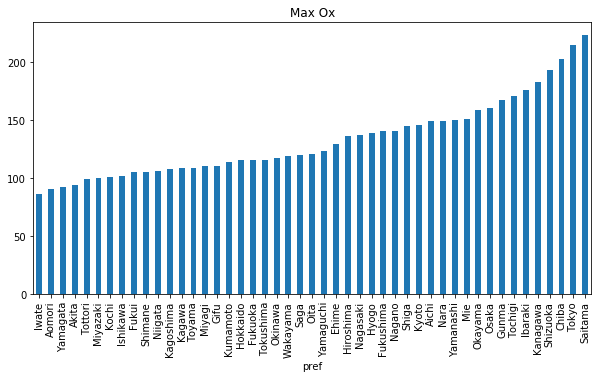

In [6]:
df_t = df.copy()
df_t.groupby('pref')['OX'].max().sort_values().plot(kind='bar', title='Max Ox', figsize=(10,5)); 

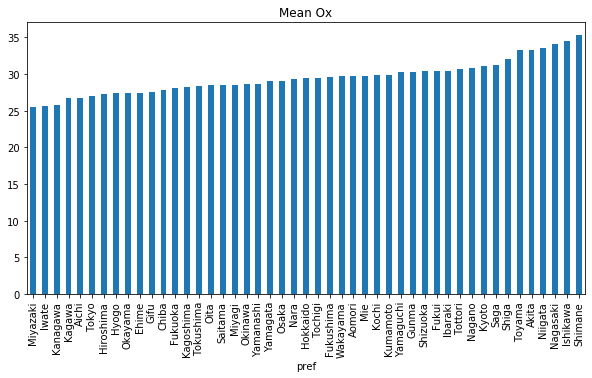

In [7]:
df_t.groupby('pref')['OX'].mean().sort_values().plot(kind='bar', title='Mean Ox', figsize=(10,5));

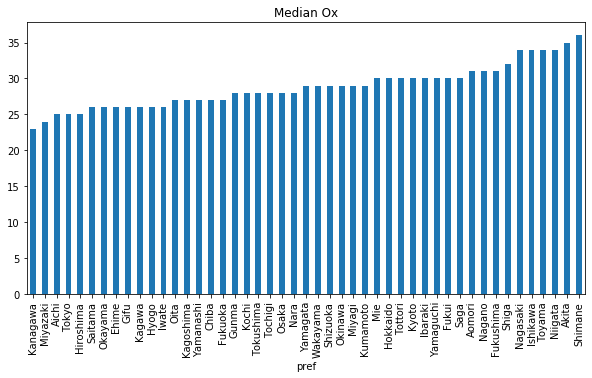

In [9]:
df_t.groupby('pref')['OX'].median().sort_values().plot(kind='bar', title='Median Ox', figsize=(10,5));

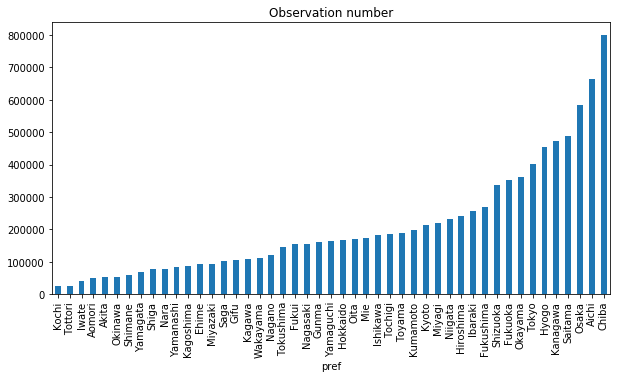

In [10]:
df_t.groupby('pref').size().sort_values().plot(kind='bar', title='Observation number', figsize=(10,5));

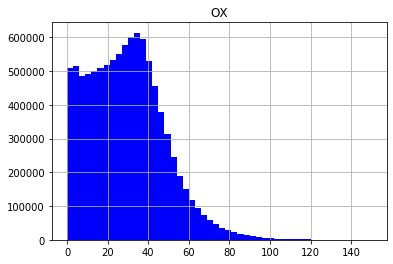

In [11]:
df_t.hist('OX', bins=50, range=[0, 150], facecolor='blue', align='mid', figsize=(6,4));

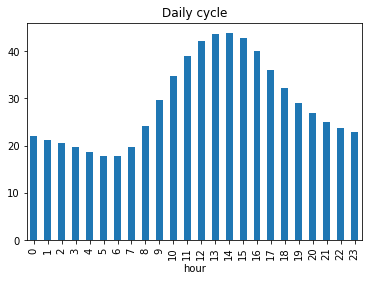

In [12]:
df_t.groupby('hour')['OX'].mean().plot(kind='bar', title='Daily cycle', figsize=(6,4));

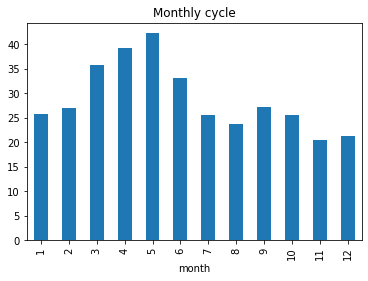

In [13]:
df_t.groupby('month')['OX'].mean().plot(kind='bar', title='Monthly cycle', figsize=(6,4));

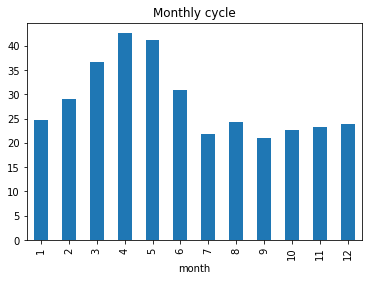

In [14]:
df = df_t.loc[df_t['pref'] == 'Hokkaido']
df.groupby('month')['OX'].mean().plot(kind='bar', title='Monthly cycle', figsize=(6,4));

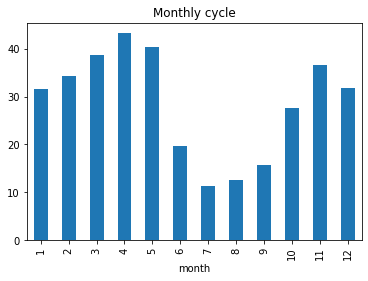

In [15]:
df = df_t.loc[df_t['pref'] == 'Okinawa']
df.groupby('month')['OX'].mean().plot(kind='bar', title='Monthly cycle', figsize=(6,4));

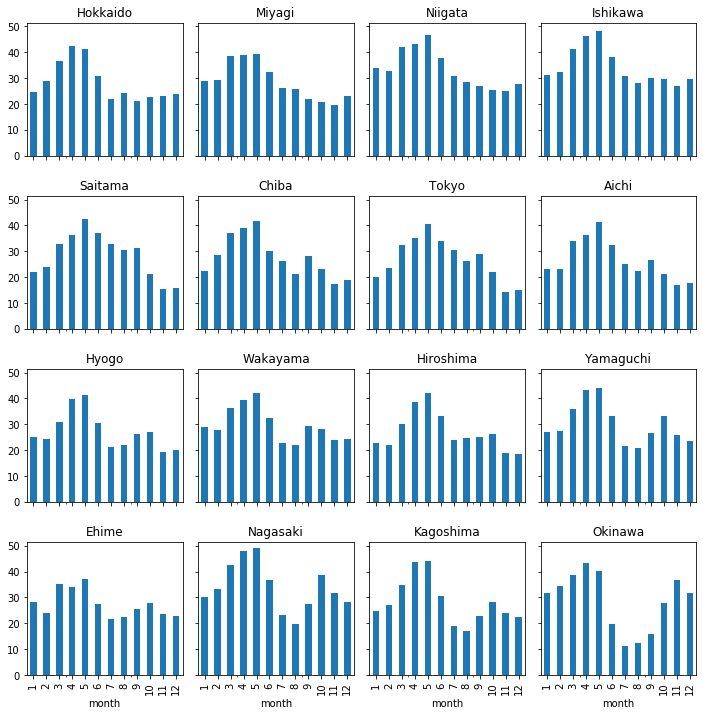

In [16]:
prf = ['Hokkaido', 'Miyagi', 'Niigata', 'Ishikawa', 
       'Saitama', 'Chiba', 'Tokyo', 'Aichi', 
       'Hyogo', 'Wakayama', 'Hiroshima', 'Yamaguchi', 
       'Ehime', 'Nagasaki', 'Kagoshima', 'Okinawa']
fig, axx = plt.subplots(4, 4, figsize=(12,12), sharex='all', sharey='all')
fig.subplots_adjust(hspace=0.3, wspace=0.1)
for j in range(0, len(prf)):
    df_t.loc[df_t['pref'] == prf[j]].groupby('month')['OX'].mean().plot(kind='bar', title=prf[j], ax=axx.flat[j]);

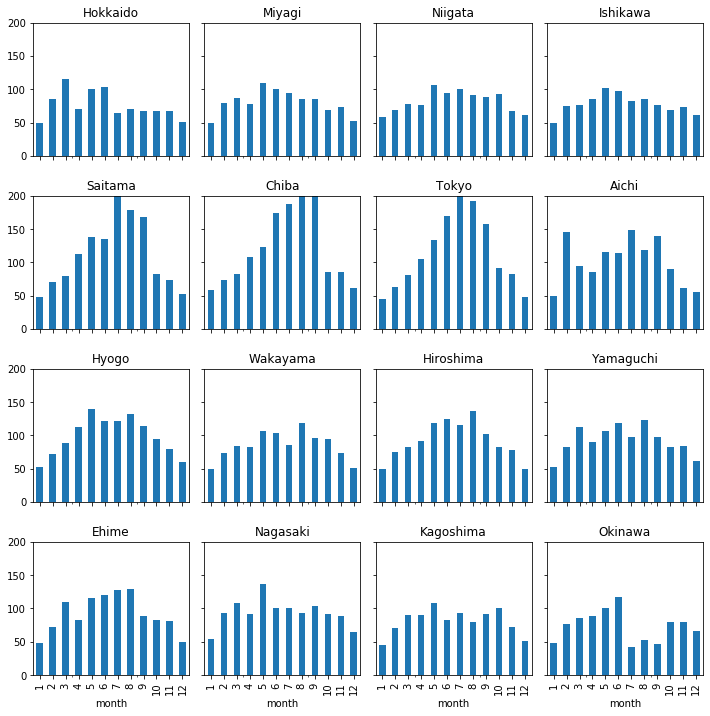

In [17]:
fig, axx = plt.subplots(4, 4, figsize=(12,12), sharex='all', sharey='all')
fig.subplots_adjust(hspace=0.3, wspace=0.1)
for j in range(0, len(prf)):
    df_t.loc[df_t['pref'] == prf[j]].groupby('month')['OX'].max().plot(kind='bar', title=prf[j], ax=axx.flat[j]);
    axx.flat[j].set_ylim(0, 200)

### Kanto

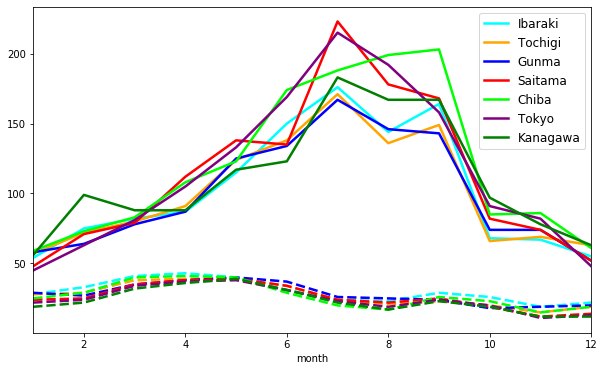

In [20]:
prf = ['Ibaraki', 'Tochigi', 'Gunma', 'Saitama', 'Chiba', 'Tokyo', 'Kanagawa']
fig, axx = plt.subplots(figsize=(10,6))
f_size = 12
colors = ['Cyan', 'Orange', 'Blue', 'Red', 'Lime', 'Purple', 'Green', 'Grey']
for j in range(0, len(prf)):
    df_t.loc[df_t['pref'] == prf[j]].groupby('month')['OX'].max().plot(
        kind='line', lw=2.5, ls='-', color=colors[j], label=prf[j], ax=axx);
    df_t.loc[df_t['pref'] == prf[j]].groupby('month')['OX'].median().plot(
        kind='line', lw=2.5, ls='--', color=colors[j], label='', ax=axx);
axx.legend(loc="upper right", ncol=1, fontsize= f_size)


### North to South

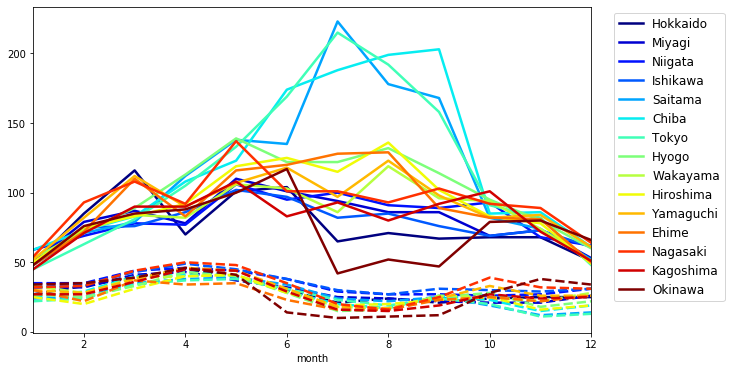

In [26]:
prf = ['Hokkaido', 'Miyagi', 'Niigata', 'Ishikawa', 
       'Saitama', 'Chiba', 'Tokyo', 
       'Hyogo', 'Wakayama', 'Hiroshima', 'Yamaguchi', 
       'Ehime', 'Nagasaki', 'Kagoshima', 'Okinawa']
fig, axx = plt.subplots(figsize=(10,6))
f_size = 12
colors = ['Cyan', 'Orange', 'Blue', 'Red', 'Lime', 'Purple', 'Green', 'Grey', 
          'Cyan', 'Orange', 'Blue', 'Red', 'Lime', 'Purple', 'Green', 'Grey']

number = len(prf)
cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, number)]

for j in range(0, len(prf)):
    df_t.loc[df_t['pref'] == prf[j]].groupby('month')['OX'].max().plot(
        kind='line', lw=2.5, ls='-', color=colors[j], label=prf[j], ax=axx);
    df_t.loc[df_t['pref'] == prf[j]].groupby('month')['OX'].median().plot(
        kind='line', lw=2.5, ls='--', color=colors[j], label='', ax=axx);
axx.legend(loc="upper right", ncol=1, fontsize= f_size, bbox_to_anchor=(1.25, 1))

### Regions

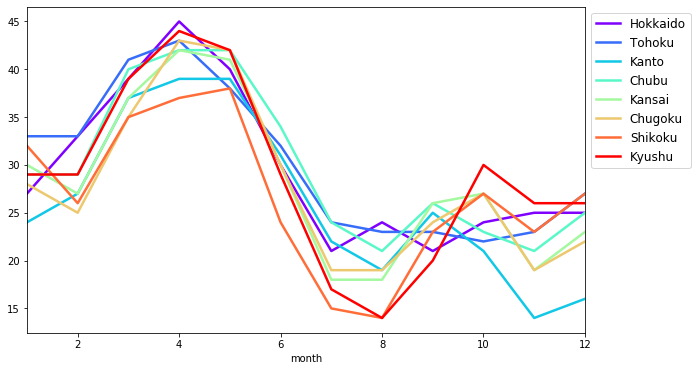

In [44]:
reg = ['Hokkaido', 'Tohoku', 'Kanto', 'Chubu', 'Kansai', 'Chugoku', 'Shikoku', 'Kyushu']
fig, axx = plt.subplots(figsize=(10,6))
f_size = 12
number = len(reg)
cmap = plt.get_cmap('rainbow')
colors = [cmap(i) for i in np.linspace(0, 1, number)]

for j in range(0, len(reg)):
    df_t.loc[df_t['region'] == reg[j]].groupby('month')['OX'].median().plot(kind='line', 
            lw=2.5, ls='-', color=colors[j], label=reg[j], ax=axx)
axx.legend(loc="upper right", ncol=1, fontsize= f_size, bbox_to_anchor=(1.2, 1));

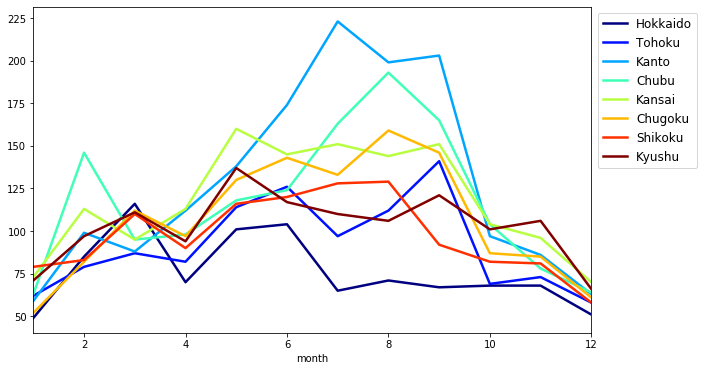

In [45]:
fig, axx = plt.subplots(figsize=(10,6))
f_size = 12
number = len(reg)
cmap = plt.get_cmap('jet')
colors = [cmap(i) for i in np.linspace(0, 1, number)]

for j in range(0, len(reg)):
    df_t.loc[df_t['region'] == reg[j]].groupby('month')['OX'].max().plot(
        kind='line', lw=2.5, ls='-', color=colors[j], label=reg[j], ax=axx)
axx.legend(loc="upper right", ncol=1, fontsize= f_size, bbox_to_anchor=(1.2, 1));

In [24]:
print(df.head())
print(df.tail())

            year   site_id  city_id  month  day    OX  hour pref1     pref  \
index                                                                        
2010-04-01  2010  47201140      201      4    1  44.0     0    47  Okinawa   
2010-04-02  2010  47201140      201      4    2  40.0     0    47  Okinawa   
2010-04-03  2010  47201140      201      4    3  54.0     0    47  Okinawa   
2010-04-04  2010  47201140      201      4    4  60.0     0    47  Okinawa   
2010-04-05  2010  47201140      201      4    5  26.0     0    47  Okinawa   

            region  
index               
2010-04-01  Kyushu  
2010-04-02  Kyushu  
2010-04-03  Kyushu  
2010-04-04  Kyushu  
2010-04-05  Kyushu  
                     year   site_id  city_id  month  day    OX  hour pref1  \
index                                                                        
2010-03-27 23:00:00  2010  47322010      213      3   27  49.0    23    47   
2010-03-28 23:00:00  2010  47322010      213      3   28  53.0    23    